# Figure 4I
## NT decoding

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.plot as uplot
import uncaging.stats as ustats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-4i.yaml'
params = uutils.load_params( params_path )

These could be put in the params `.yaml` file if you'd like, but they're the most likely to be modulated so for simplicity let's have them here:

In [3]:
# Choices for `analysis`:
# * 'wt' - wild-type dataset
# * 'cx43' - connexin-43 conditional knock out dataset
params['analysis'] = 'wt'

#### Initial setup

In [4]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent'],
)

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [5]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 31.19it/s] 
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 24.27it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 32.98it/s]



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99



In [6]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### 4I: NT decoding

In [7]:
events_subset = events_prop.copy()

filter_events_condition = events_subset['condition'].isin( params['comparison'] )
filter_events_neighbor = events_subset['is_uncage'] == False

filter_events_panel = filter_events_condition & filter_events_neighbor
events_panel = events_subset.copy()[filter_events_panel]

In [8]:
uevents.summarize_n( events_panel )

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 250
Cells:           n = 167
Events:          n = 2470
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  1
    High: 52

** GABA:
Datasets:        n = 28
Cell-recordings: n = 135
Events:          n = 1358
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 115
Events:          n = 1112
Cells per dataset:
    Low:  1
    High: 7


#### Feature extraction

In [9]:
windows = [
    params['rate_windows']['baseline'],
    params['rate_windows']['post'],
]

point_rates = uevents.group_rates(
    events_panel, params['rate_point_key'],
    keep_keys = ['condition'],
    windows = windows,
)

point_rates['rel'] = np.array( [ x / y if y > 0 else np.nan
                                 for x, y in zip( point_rates['rate_2'], point_rates['rate_1'] ) ] )
point_rates['diff'] = point_rates['rate_2'] - point_rates['rate_1']

In [10]:
features = np.array( point_rates['rel'] )
labels = np.array( point_rates['condition'] == params['comparison'][1] ).astype( int )

label_conditions = { k: params['comparison'][k]
                     for k in [0, 1] }

In [11]:
filter_valid = ~np.isnan( features )

features = features[filter_valid].copy()
labels = labels[filter_valid].copy()

In [12]:
from scipy.stats import gaussian_kde

kdes = { k: gaussian_kde( features[labels == k ] )
         for k in [0, 1] }

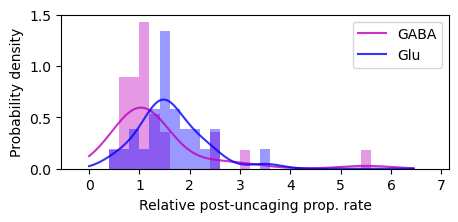

In [13]:
xs = np.arange( 0, np.max( features ) + 1., 0.05 )
hist_bins = np.arange( -0.2, 7.0, 0.2 )

plt.figure( figsize = (5, 2) )

for label, kde in kdes.items():
    data = features[labels == label]
    color = helper.condition_colors[label_conditions[label]]
    plt.hist( data,
              color = color,
              alpha = 0.4,
              bins = hist_bins,
              density = True )
    plt.plot( xs, kde.pdf( xs ),
              color = color,
              alpha = 0.8,
              label = label_conditions[label] )

plt.xlabel( 'Relative post-uncaging prop. rate' )
plt.ylabel( 'Probability density' )

plt.legend()

plt.show()

#### Decoder

In [14]:
def decode_threshold( X,
                      threshold = 0. ):
    return np.array( X >= threshold ).astype( int )

#### ROC Analysis

In [15]:
def roc_threshold( X, y, decoder,
                   thresholds = None ):
    
    if thresholds is None:
        thresholds = np.arange( 0, 1, 0.01 )
        
    tprs = np.zeros( (thresholds.shape[0],) )
    fprs = np.zeros( (thresholds.shape[0],) )
    
    for i, threshold in enumerate( thresholds[::-1] ):
        y_hat = decoder( X, threshold = threshold )
        
        tp = np.sum( (y_hat == 1) & (y == 1) )
        fp = np.sum( (y_hat == 1) & (y == 0) )
        tn = np.sum( (y_hat == 0) & (y == 0) )
        fn = np.sum( (y_hat == 0) & (y == 1) )
        
        tprs[i] = tp / (tp + fn)
        fprs[i] = fp / (fp + tn)
    
    return tprs, fprs

def roc_auc( tprs, fprs ):
#     idx = np.argsort( fprs )
    return np.trapz( tprs, x = fprs )

In [16]:
feature_min = np.min( features )
feature_max = np.max( features )
feature_diff = feature_max - feature_min

thresh_min = feature_min - (0.1 * feature_diff)
thresh_max = feature_max + (0.1 * feature_diff)
n_thresh = 1000

thresholds = np.linspace( thresh_min, thresh_max, n_thresh )

In [17]:
roc_tprs, roc_fprs = roc_threshold( features, labels, decode_threshold,
                                    thresholds = thresholds )

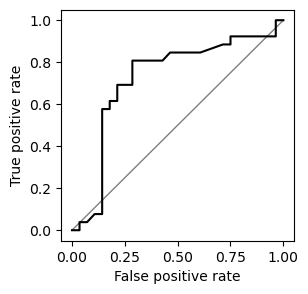

In [18]:
plt.figure( figsize = (3, 3) )

# idx_sort = np.argsort( roc_fprs )
plt.plot( roc_fprs, roc_tprs, 'k-', markersize = 1. )

plt.plot( [0, 1], [0, 1], 'k-', linewidth = 1, alpha = 0.5 )

plt.ylabel( 'True positive rate' )
plt.xlabel( 'False positive rate' )

save_figure( 'decode-nt-prop-rel-roc' )

plt.show()

In [19]:
auc_true = roc_auc( roc_tprs, roc_fprs )
print( f'AUC: {auc_true}' )

AUC: 0.7218406593406592


#### Bootstrap

In [20]:
auc_boot = np.zeros( (params['n_boot'],) )
for i_boot in tqdm( range( params['n_boot'] ) ):

    # Take bootstrap sample
    idx_boot = np.random.randint( features.shape[0], size = (features.shape[0],) )
    features_boot = features[idx_boot]
    labels_boot = labels[idx_boot]

    roc_tprs, roc_fprs = roc_threshold( features_boot, labels_boot, decode_threshold,
                                        thresholds = thresholds )
    auc_boot[i_boot] = roc_auc( roc_tprs, roc_fprs )

auc_low, auc_high = np.quantile( auc_boot, [0.025, 0.975] )

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [05:23<00:00, 30.95it/s]


In [21]:
auc_se = np.std( auc_boot )
print( f'AUC: {auc_true:0.4f} +/- {auc_se:0.4f}' )

AUC: 0.7218 +/- 0.0764


For bootstrap plots:
* The top line is the statistic +/- 1 bootstrap SE.
* The bottom line is the bootstrap $(0.025, 0.5, 0.975)$ quantiles.

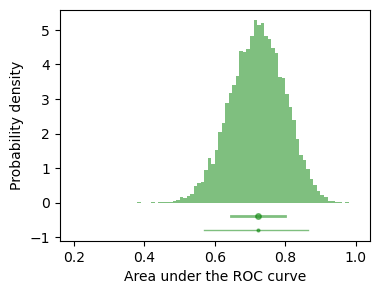

In [22]:
bins_boot = np.arange( 0.2, 1.01, 0.01 )

fig, ax = plt.subplots( figsize = (4, 3) )

uplot.plot_boot(
    ax, auc_boot, auc_true,
    color = 'g',
    bins = bins_boot,
)

plt.xlabel( 'Area under the ROC curve' )
plt.ylabel( 'Probability density' )

plt.show()

#### Permutation testing

In [23]:
auc_perm = np.zeros( (params['n_perm'],) )
for i_perm in tqdm( range( params['n_perm'] ) ):
    labels_perm = np.random.permutation( labels )
    roc_tprs_perm, roc_fprs_perm = roc_threshold( features, labels_perm, decode_threshold,
                                                  thresholds = thresholds )
    auc_perm[i_perm] = roc_auc( roc_tprs_perm, roc_fprs_perm )

100%|██████████| 10000/10000 [06:04<00:00, 27.46it/s]


In [24]:
p_perm = ustats.perm_p(
    np.sum( auc_perm >= auc_true ),
    auc_perm.shape[0],
)

In [25]:
print( f'AUC: {auc_true:0.4f} +/- {auc_se:0.4f}' )
print( f'    p = {p_perm}' )

AUC: 0.7218 +/- 0.0764
    p = 0.0018998100189981002


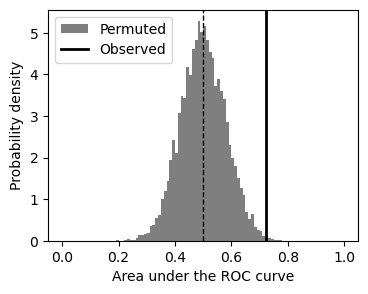

In [26]:
bins_perm = np.arange( 0., 1.01, 0.01 )

fig, ax = plt.subplots( figsize = (4, 3) )

uplot.plot_perm(
    ax, auc_perm, auc_true,
    color = 'k',
    bins = bins_perm,
    null = 0.5,
)

plt.legend()

plt.xlabel( 'Area under the ROC curve' )
plt.ylabel( 'Probability density' )

save_figure( 'decode-nt-prop-rel-auc-perm-hist' )

plt.show()